In [1]:
# imports for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

# Data analysis

First of all, it would be nice to define data points that should be discovered:
 * if the image size in dataset is homogeneous
 * is there any corrupted/damaged/repeated images
 * distribution by number of ships (according to data description there images with more than 1 ship on it)
 * distribution by ship size or area taken by ships 

## Upload dataset information into DataFrame

In [35]:
# Define all necessary path for better code reproduction
data_folder = './data/'
train_folder = os.path.join(data_folder, 'train_v2/')
test_folder = os.path.join(data_folder, 'test_v2/')


In [36]:
# read the dataset information into DataFrame
dataset = pd.read_csv(os.path.join(data_folder, 'train_ship_segmentations_v2.csv'))

dataset.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


## Data preparation

### In the cell below would be defined useful function that will be used later on for data exploration.

In [73]:
# imports of custom function
from utils.local_utils import get_image_mask

# got issue with exporting get_image to .ipynb,
# so defining it here 
def get_image(folder, img_name):
    img = cv2.imread(os.path.join(folder, img_name))
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

def get_img_shape(img_name):
    '''Returns the (image_width, img_height).'''
    img = cv2.imread(os.path.join(train_folder, img_name))
    return img.shape[:2]

def get_area_in_pixels(mask_rle):
    '''Returns the sum of non-zero pixels in mask.'''
    # sum only ship mask pixels from RLE
    return [np.array(x.split(), dtype=np.int32)[1::2].sum() if pd.notna(x) else 0 for x in mask_rle.to_list()]


### Extend DataFrame with required data points

In [37]:
# get height and width for all images
for n_row, data in dataset.iterrows():
    if not n_row%1000:
        print(f'Processing the {n_row} row')
    shape = get_img_shape(data['ImageId'])
    dataset.loc[n_row, 'ImageHeight'] = shape[1]
    dataset.loc[n_row, 'ImageWidth'] = shape[0]

Processing the 0 row
Processing the 1000 row
Processing the 2000 row
Processing the 3000 row
Processing the 4000 row


KeyboardInterrupt: 

In [48]:
dataset.sample(5)

,ImageId,EncodedPixels,ImageHeight,ImageWidth,HasShip
83240,5bf2459fa.jpg,NaN,768.0,768.0,0
115539,7f6aca2aa.jpg,NaN,768.0,768.0,0
28372,1f91668f8.jpg,NaN,768.0,768.0,0
193381,d5d70c05e.jpg,NaN,768.0,768.0,0
123673,8890c297e.jpg,NaN,768.0,768.0,0


In [49]:
# add if the mask exists for each instance
dataset = dataset.assign(HasShip = pd.notna(dataset['EncodedPixels']).astype(int))
dataset.sample(10)

,ImageId,EncodedPixels,ImageHeight,ImageWidth,HasShip
155100,ab5d322f5.jpg,501684 1 502451 4 503219 5 503986 8 504753 10 ...,768.0,768.0,1
81694,5a3090700.jpg,NaN,768.0,768.0,0
64240,4720f286a.jpg,38335 1 39103 3 39870 6 40638 8 41405 11 42173...,768.0,768.0,1
136023,9620a64f5.jpg,NaN,768.0,768.0,0
62418,451077065.jpg,433182 1 433948 4 434715 5 435481 8 436248 10 ...,768.0,768.0,1
116676,80b16ce8d.jpg,NaN,768.0,768.0,0
139701,9a31899ac.jpg,NaN,768.0,768.0,0
180698,c7976f62a.jpg,143396 15 144164 15 144932 15 145700 15 146468...,768.0,768.0,1
40637,2d1cd0c47.jpg,NaN,768.0,768.0,0
5374,05d7757e9.jpg,NaN,768.0,768.0,0


In [50]:
# get ship area in pixels
dataset = dataset.assign(ShipArea = get_area_in_pixels(dataset['EncodedPixels']))
dataset.head()

,ImageId,EncodedPixels,ImageHeight,ImageWidth,HasShip,ShipArea
0,00003e153.jpg,NaN,768.0,768.0,0,0
1,0001124c7.jpg,NaN,768.0,768.0,0,0
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,768.0,768.0,1,3388
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,768.0,768.0,1,177
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...,768.0,768.0,1,148


In [161]:
# save the dataset for later use
dataset.to_csv('./data/processed_df.csv')

## Data points analysis

In [51]:
dataset = pd.read_csv('./data/processed_df.csv')

In [54]:
print(f'The len of the dataset is {len(dataset)}')
print(f"The number of unique images in dataset is {dataset['ImageId'].nunique()}")

The len of the dataset is 231723
The number of unique images in dataset is 192556


In [55]:
# check if the all images were processed 
# and if the image size is homogeneous throughout the data
dataset[['ImageHeight', 'ImageWidth']].value_counts()

ImageHeight  ImageWidth
768.0        768.0         231723
dtype: int64

As it occurs, all images were loaded properly and image size is the same for all images (768, 768, 3).

Let's create the image-vise dataset with ship numbers and area.

In [65]:
# create the dataset groupped by ImageId to explore distributions
group_by_dataset = dataset[['ImageId', 'HasShip', 'ShipArea']].groupby('ImageId').sum()
group_by_dataset.sample(10)

,HasShip,ShipArea
ImageId,,
aefe37ab9.jpg,0,0
6341a6903.jpg,1,168
40a9a506c.jpg,0,0
35f0e56b2.jpg,1,5373
5ead8d278.jpg,0,0
46cf508f4.jpg,0,0
7706b1f40.jpg,0,0
f3a34aadf.jpg,0,0
00a9b7ec4.jpg,0,0


Now, let's check if any data went missing while performing operations, so we would be sure that we get consistent results.

In [71]:
s = f'''As we remember, the number of unique images in original dataset is {dataset['ImageId'].nunique()}.
And the number of unique images in Groupped DataFrame is {len(group_by_dataset)}.
The datasets has same length is {dataset['ImageId'].nunique() == len(group_by_dataset)}.
'''
print(s)

As we remember, the number of unique images in original dataset is 192556.
And the number of unique images in Groupped DataFrame is 192556.
The datasets has same length is True.



So, we did not miss any data, moving forward.

### Distribution plots

Down below the distribution by number of ships on the each image is presented:

0     150000
1      27104
2       7674
3       2954
4       1622
5        925
6        657
7        406
8        318
9        243
10       168
11       144
12       124
14        76
13        75
15        66
Name: HasShip, dtype: int64

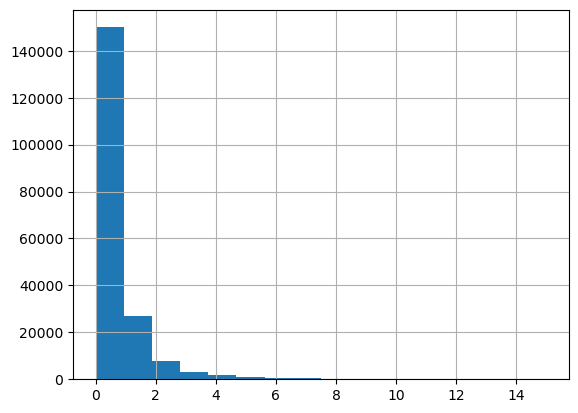

In [74]:
group_by_dataset.loc[:, 'HasShip'].hist(bins=16)
group_by_dataset.loc[:, 'HasShip'].value_counts()

As we can see, the data is very imbalanced in general dataset and it's leaning towards empty images (images without ships).

Below you can find the distribution by image area taken by ships:

In [76]:
group_by_dataset.ShipArea /= 768*768

cutted = pd.cut(group_by_dataset.loc[:, 'ShipArea'], 
                bins=[-1, 0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1, 1]).value_counts()
cutted

(-1.0, 0.0]     150000
(0.0, 0.01]      35325
(0.01, 0.02]      4833
(0.02, 0.03]      1835
(0.03, 0.04]       430
(0.04, 0.05]        88
(0.05, 0.1]         44
(0.1, 1.0]           1
Name: ShipArea, dtype: int64

<Axes: >

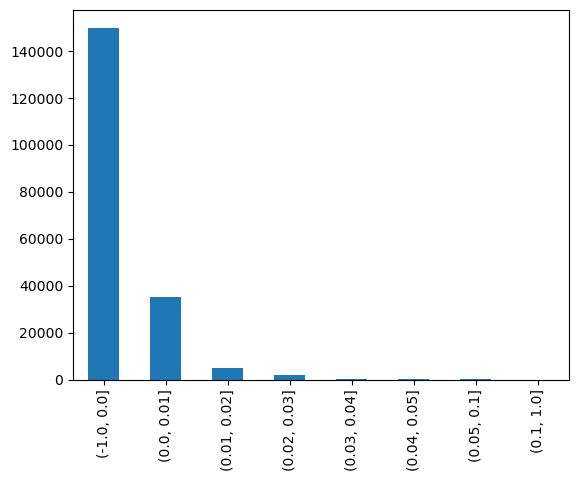

In [77]:
cutted.plot.bar()

### Overall visualization of random data samples

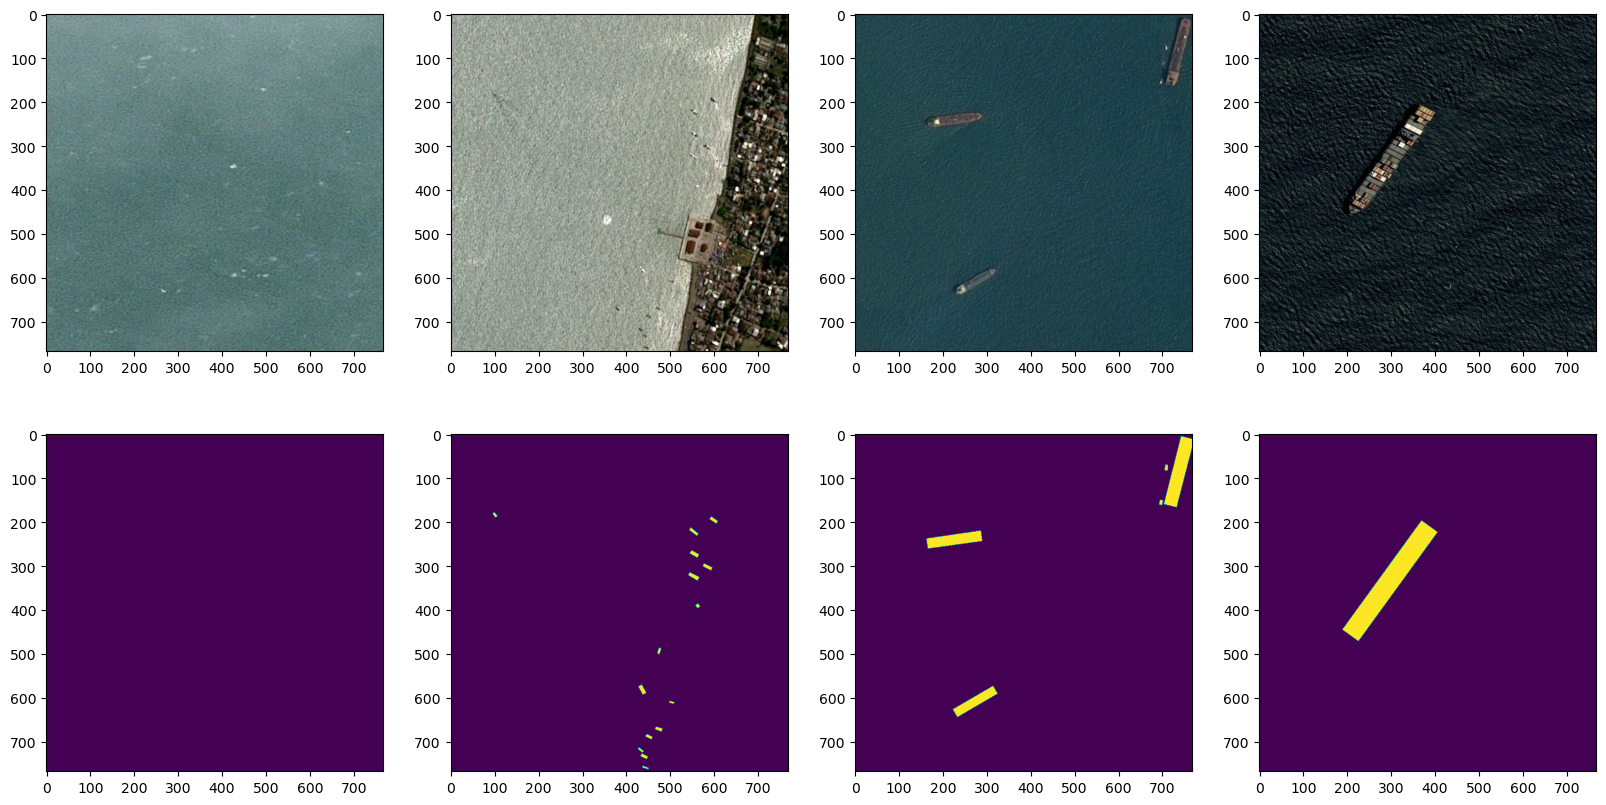

In [13]:
ims_to_visualize = ['155a58719.jpg', 'ff7ac7f3c.jpg', 'ffa79fd64.jpg', '0006c52e8.jpg']

_, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, img_name in enumerate(ims_to_visualize):
    img = get_image(train_folder, img_name)
    mask = get_image_mask(img_name, dataset)

    axs[0, i].imshow(img)
    axs[1, i].imshow(mask)

plt.show()

# Train / Validation split

So, let's move to the building the dataset that will be used for training the model. As we it was presented earlier, the data is quite imbalance, so we should consider it while building the dataset. Also, it's important to remember that it's a good practise to have the same distribution by critical data points. In this case it would be the number of ships on each image.

The pipeline for preparing dataset will look like this:
 * split the data into train/validation batches by 80/20 rule.
 * make sure that distribution by number of ships is the same in both samples.
 * remove unnesessary blank images (90% of them from each batch) to balance the distribution.
 * save the result.

### Splitting the data by 80/20 with number of ships in mind

In [78]:
from sklearn.model_selection import train_test_split

In [79]:
train_ids, validation_ids = train_test_split(group_by_dataset, 
                                             test_size = 0.2, 
                                             stratify = group_by_dataset['HasShip'])

### Presenting the distribution

In [80]:
train_ids.HasShip.value_counts()

0     119999
1      21683
2       6139
3       2363
4       1298
5        740
6        526
7        325
8        254
9        194
10       135
11       115
12        99
14        61
13        60
15        53
Name: HasShip, dtype: int64

In [81]:
validation_ids.HasShip.value_counts()

0     30001
1      5421
2      1535
3       591
4       324
5       185
6       131
7        81
8        64
9        49
10       33
11       29
12       25
14       15
13       15
15       13
Name: HasShip, dtype: int64

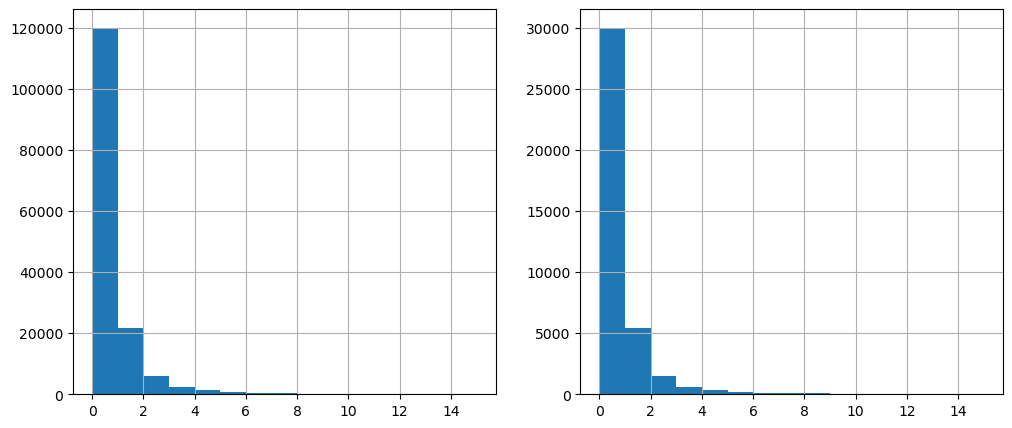

In [82]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

train_ids.HasShip.hist(bins=15, ax=ax1)
validation_ids.HasShip.hist(bins=15, ax=ax2)

plt.show()

### Removing the 90% of blank images from each batch

In [85]:
np.random.seed(10)

def to_remove(df, percent=0.9):
    '''Removes from dataframe the empty images'''
    zero_ships = df[df.HasShip==0]
    # remove 90% of empty images
    remove_n = int(len(zero_ships)*percent)
    drop_indices = np.random.choice(zero_ships.index, remove_n, replace=False)
    return df.drop(drop_indices)

<Axes: >

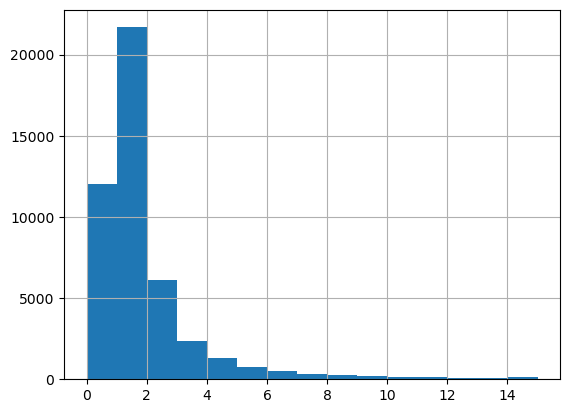

In [93]:
cleared_train_ids = to_remove(train_ids)
cleared_train_ids.HasShip.hist(bins=15)

<Axes: >

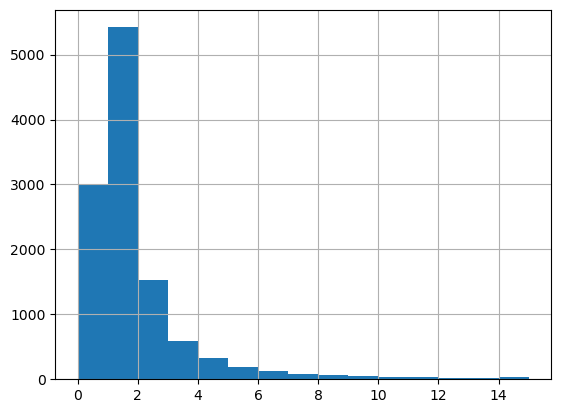

In [87]:
cleared_val_ids = to_remove(validation_ids)
cleared_val_ids.HasShip.hist(bins=15)

In [88]:
cleared_train_ids.reset_index(inplace=True)
cleared_val_ids.reset_index(inplace=True)

In [89]:
len(cleared_val_ids)

11512

In [90]:
len(cleared_train_ids)

46045

In [91]:
cleared_train_ids.sample(10)

,ImageId,HasShip,ShipArea
34215,28abc3e5d.jpg,0,0.000000
16004,233cef78e.jpg,1,0.024745
31613,7bb5dba19.jpg,1,0.000205
9719,279ac3f61.jpg,1,0.000373
11992,c84611f02.jpg,1,0.001244
31929,dccf4593d.jpg,1,0.021503
15615,7e86c4e26.jpg,1,0.000173
40449,80a7c0bca.jpg,5,0.010279
27021,238cf021c.jpg,1,0.000400
848,6db54b89d.jpg,2,0.000127


### Saving the datasets

In [92]:
cleared_val_ids['ImageId'].to_csv('./data/cleared_val_ids.csv')
cleared_train_ids['ImageId'].to_csv('./data/cleared_train_ids.csv')